In [1]:
import torch
print(torch.__version__)  # Kiểm tra phiên bản PyTorch
print(torch.cuda.is_available())  # Kiểm tra xem PyTorch có nhận GPU không
print(torch.version.cuda)  # Kiểm tra phiên bản CUDA mà PyTorch đang sử dụng
print(torch.cuda.get_device_name(0))  # Kiểm tra tên GPU

2.5.1+cu121
True
12.1
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set random seeds for reproducibility
random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

dataset_path = "./Multi Cancer/Cervical Cancer"
cervix_categories = ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']

# Load image paths and labels
image_paths, labels = [], []
label_dict = {category: idx for idx, category in enumerate(cervix_categories)}

for category in cervix_categories:
    category_path = os.path.join(dataset_path, category)
    images_list = os.listdir(category_path)
    for img in images_list:
        image_paths.append(os.path.join(category_path, img))
        labels.append(label_dict[category])

df = pd.DataFrame({'filepath': image_paths, 'label': labels})

# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Define Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((224, 224))
])

# Custom Dataset Class
class CancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Create DataLoaders
BATCH_SIZE = 32
train_dataset = CancerDataset(train_df, transform=transform)
valid_dataset = CancerDataset(valid_df, transform=transform)
test_dataset = CancerDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [4]:
# Define Model
class CancerModel(nn.Module):
    def __init__(self):
        super(CancerModel, self).__init__()
        self.model = models.resnet101(pretrained=True)
        self.model.classifier = nn.Linear(1792, len(cervix_categories))
        nn.init.xavier_normal_(self.model.classifier.weight)

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CancerModel().to(device)

# Load best model
model.load_state_dict(torch.load("cervical_cancer_model.pth"), strict=False)
model.eval()

c:\Users\tranh\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tranh\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\tranh\AppData\Local\Temp\ipykernel_304\853802388.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/py

CancerModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [5]:
target_layer = model.model.layer4[-1].conv3 

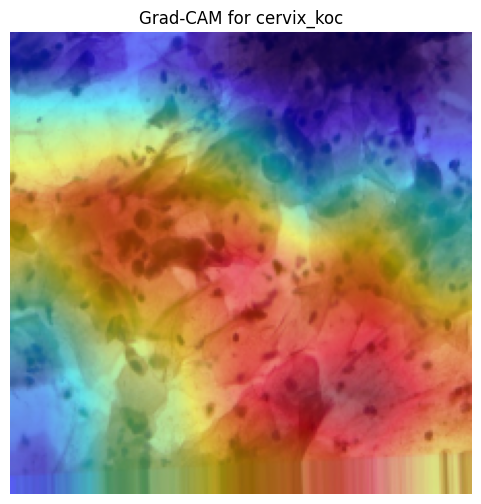

In [11]:
# Grad-CAM for Explainability
target_layers = [model.model.layer4[-1].conv3] 
cam = GradCAM(model=model, target_layers=target_layers)

def grad_cam_image(idx, category):
    path = df[df['label'] == label_dict[category]].iloc[idx]['filepath']
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0).to(device)
    img_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
    
    pred = int(torch.argmax(torch.nn.functional.softmax(model(img_tensor), dim=1)).item())
    targets = [ClassifierOutputTarget(pred)]
    
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img_resized.astype(np.float32) / 255, grayscale_cam, use_rgb=True)
    
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(visualization)
    plt.title(f'Grad-CAM for {category}')
    plt.show()

# Example Grad-CAM visualization
grad_cam_image(15, 'cervix_koc')


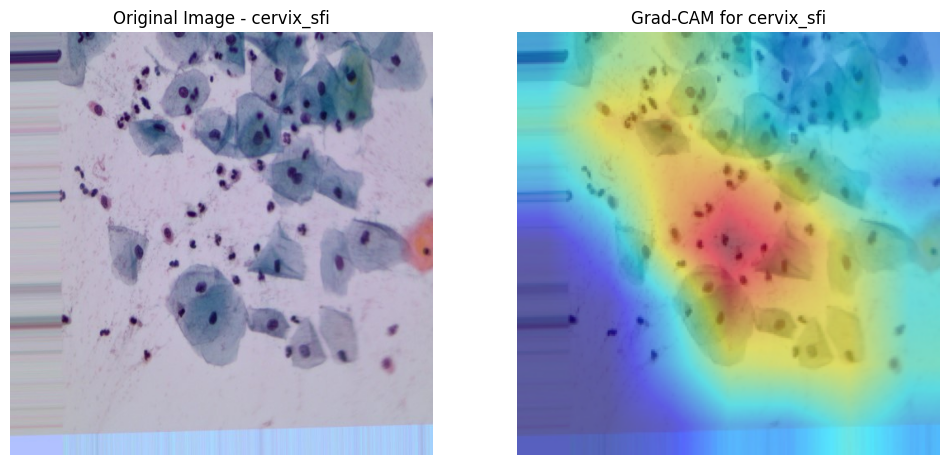

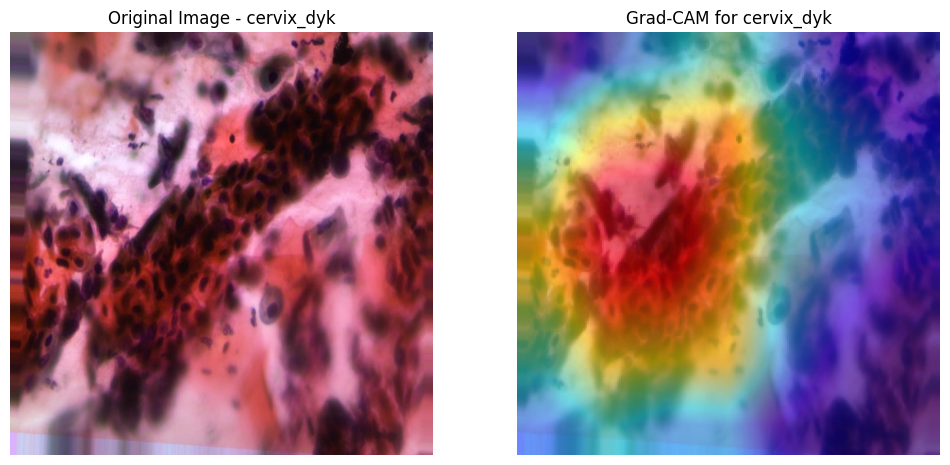

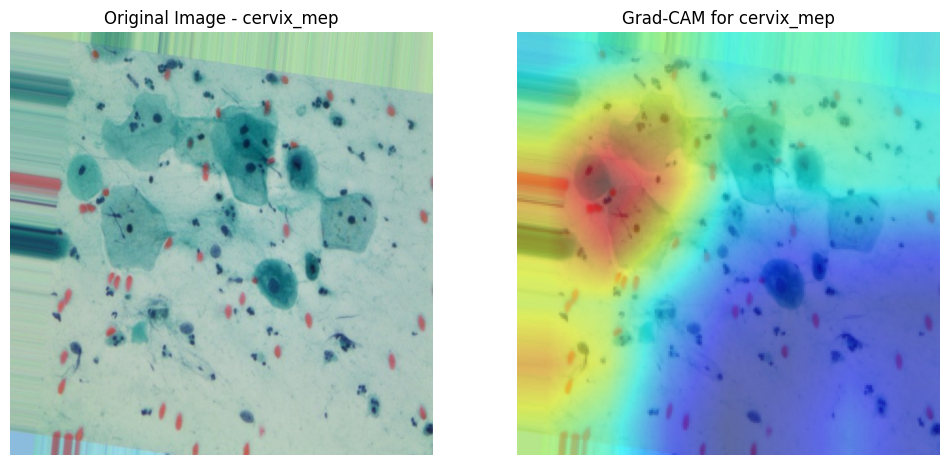

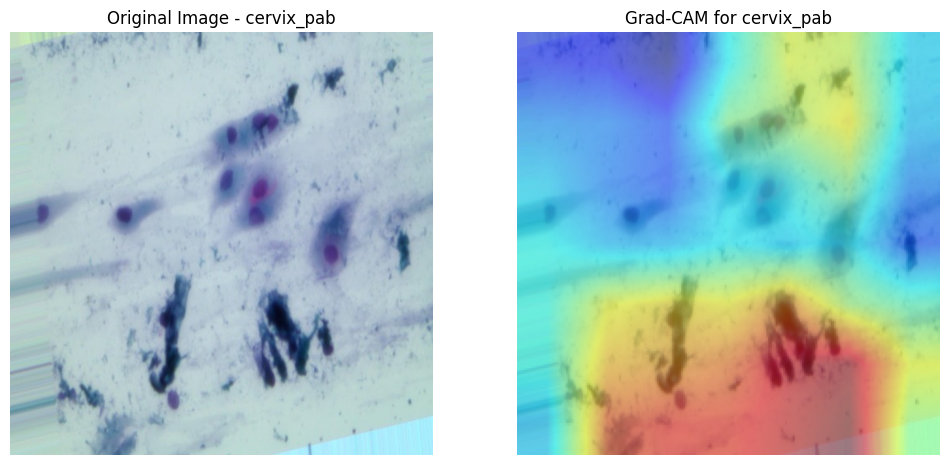

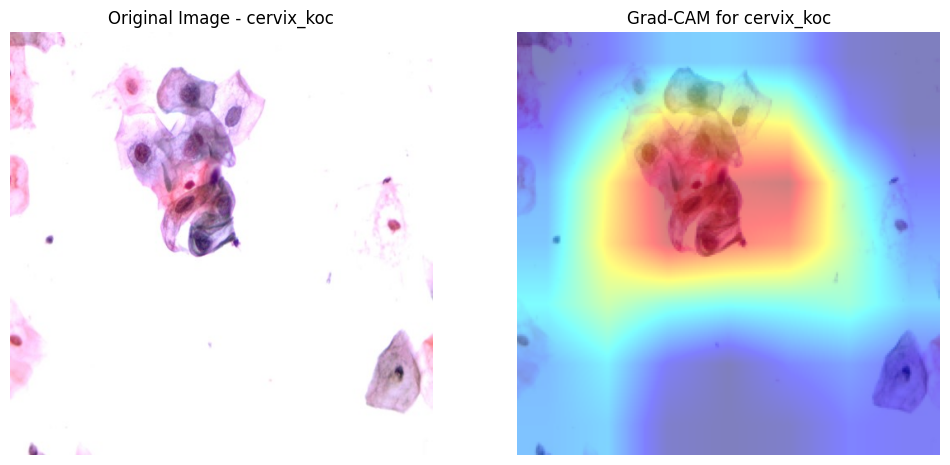

In [17]:
def compare_grad_cam(idx, category):
    path = df[df['label'] == label_dict[category]].iloc[idx]['filepath']
    
    # Load original image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize to match model input
    img_resized = cv2.resize(img, (224, 224))
    
    # Convert to tensor and normalize
    img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0).to(device)
    img_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
    
    # Get model prediction
    pred = int(torch.argmax(torch.nn.functional.softmax(model(img_tensor), dim=1)).item())
    targets = [ClassifierOutputTarget(pred)]
    
    # Generate Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img_resized.astype(np.float32) / 255, grayscale_cam, use_rgb=True)
    
    # Plot original image and Grad-CAM side by side
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(f'Original Image - {category}')
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(visualization)
    plt.title(f'Grad-CAM for {category}')
    
    plt.show()

# Run comparison
compare_grad_cam(21, 'cervix_sfi')
compare_grad_cam(21, 'cervix_dyk')
compare_grad_cam(21, 'cervix_mep')
compare_grad_cam(21, 'cervix_pab')
compare_grad_cam(21, 'cervix_koc')